# Connect to Server and Create Schema

In [1]:
import datajoint as dj
dj.config['enable_python_native_blobs'] = True

In [2]:
schema = dj.Schema('{user}_style'.format(user=dj.config['database.user']))

Connecting dimitri@db.data-science-ust.net:3306


# Define tables 

In [3]:
@schema
class Sport(dj.Lookup):
    definition = """
    sport_id        :  int 
    ---
    name      : varchar(30)
    sex : enum("women", "men")
    unique index(name, sex)
    """
    
    contents = (
        (1, 'swim', 'women'),
        (2, 'soc', 'women'),
        (3, 'track', 'men'),
        (4, 'football', 'men')
    )

In [4]:
Sport()

sport_id,name,sex
4,football,men
2,soc,women
1,swim,women
3,track,men


In [5]:
@schema
class NewsArticle(dj.Manual):
    definition = """
    -> Sport
    news_id       : int
    ---
    date=null: date
    """

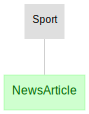

In [6]:
dj.Di(schema)

In [7]:
NewsArticle.insert([
    [4, 1, "2020-03-03"],
    [2, 1, "2019-11-05"],
    [1, 1, "2020-03-11"],
    [3, 1, "2020-03-04"],
], skip_duplicates=True)

In [8]:
NewsArticle()

sport_id,news_id,date
1,1,2020-03-11
2,1,2019-11-05
3,1,2020-03-04
4,1,2020-03-03


In [9]:
import requests
import json
import re
from os import path, mkdir

from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

In [10]:
@schema
class Headline(dj.Imported):
    definition = """
    -> NewsArticle
    ---
    name : varchar(200)
    image: longblob
    """
    
    def make(self, key):    
        sport_name, sport_sex = (Sport & key).fetch1('name', 'sex')
        news_date = (NewsArticle & key).fetch1('date')
        file_path = 'cached/{}_{}_{}.JPG'.format(sport_name, sport_sex, news_date)
        
        base_url = "https://uhcougars.com"
        headers = {
            'User-Agent': "DataJoint"
        }
        querystring = {
            "index":"1",
            "page_size":"30",
            "sport": sport_name if sport_sex != 'women' else sport_sex[0] + sport_name,
            "season":"0"
        }
        response = requests.request("GET", base_url + "/services/archives.ashx/stories", headers=headers, params=querystring)
        article = [v for v in json.loads(response.text)['data'] if v['story_postdate'] == news_date.strftime("%-m/%-d/%Y")][0] if news_date else json.loads(response.text)['data'][0]
        news_date = datetime.datetime.strptime(article['story_postdate'], '%m/%d/%Y').date() if not news_date else news_date
        response = requests.request("GET", base_url + article['story_path'], headers=headers)
        image_path = re.findall(r'<img src="/images/{year}[A-Za-z0-9/_.\-]+'.format(year=news_date.year), response.text)[0][10:]
        response = requests.request("GET", base_url + image_path, headers=headers)
        if not path.exists(path.dirname(file_path)):
            mkdir(path.dirname(file_path))
        with open(file_path, 'wb') as f:
            f.write(response.content)
        print('Image `{}` downloaded.'.format(file_path))
            
        self.insert1(dict(
            key, 
            name=article['story_headline'], 
            image=plt.imread(file_path)))

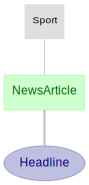

In [11]:
dj.Di(schema)

In [12]:
Headline.populate()

Image `cached/swim_women_2020-03-11.JPG` downloaded.
Image `cached/soc_women_2019-11-05.JPG` downloaded.
Image `cached/track_men_2020-03-04.JPG` downloaded.
Image `cached/football_men_2020-03-03.JPG` downloaded.


In [13]:
Headline()

sport_id,news_id,name,image
1,1,Houston Concludes NCAA Zone D Diving Championships,=BLOB=
2,1,Bowen and Grant Earn Regular Season Honors,=BLOB=
3,1,Three Cougars Tabbed As Most Outstanding Performers,=BLOB=
4,1,Fans Invited to Open Practice on Friday,=BLOB=


In [14]:
key = dict(sport_id=3, news_id=1)
Headline() & key 

sport_id,news_id,name,image
3,1,Three Cougars Tabbed As Most Outstanding Performers,=BLOB=


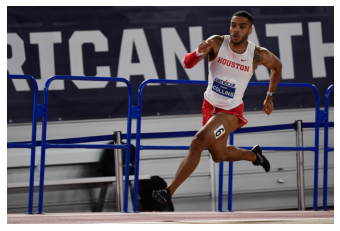

In [15]:
plt.imshow((Headline & key).fetch1('image'))
plt.axis(False);

In [16]:
@schema
class PaintingStyle(dj.Lookup):
    definition = """
    style_name      : varchar(30)
    """
    contents = (['udnie'], ['la_muse'], ['starry_night'], ['mosaic'])


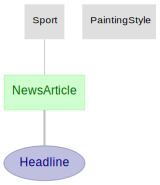

In [17]:
dj.Di(schema)

In [18]:
PaintingStyle()

style_name
la_muse
mosaic
starry_night
udnie


In [19]:
import numpy as np
import cv2
import imutils

In [20]:
@schema
class Flyer(dj.Computed):
    definition = """
    -> Headline
    -> PaintingStyle
    ---
    image: longblob
    """
    def make(self, key):
        style_path = 'models/' + key['style_name'] + '.t7'
        image = (Headline & key).fetch1('image')
        
        net = cv2.dnn.readNetFromTorch(style_path)    
        image = imutils.resize(image, width=600)
        (h, w) = image.shape[:2]

        # construct a blob from the image, set the input, and then perform a
        # forward pass of the network
        blob = cv2.dnn.blobFromImage(image, 1.0, (w, h),
            (103.939, 116.779, 123.680), swapRB=False, crop=False)
        net.setInput(blob)
        output = net.forward()

        # reshape the output tensor, add back in the mean subtraction, and
        # then swap the channel ordering
        output = output.reshape((3, output.shape[2], output.shape[3]))
        output[0] += 103.939
        output[1] += 116.779
        output[2] += 123.680
        output = output.transpose(1, 2, 0)
        output = np.clip(output, 0, 255)
        output= output.astype('uint8')
        
        print('sport_id: {sport_id}, news_id: {news_id}, style_name: {style_name}'.format(**key))
        self.insert1(dict(key, image=output))

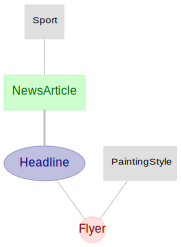

In [21]:
dj.Di(schema)

In [22]:
Flyer.populate()

sport_id: 1, news_id: 1, style_name: la_muse
sport_id: 2, news_id: 1, style_name: la_muse
sport_id: 3, news_id: 1, style_name: la_muse
sport_id: 4, news_id: 1, style_name: la_muse
sport_id: 1, news_id: 1, style_name: mosaic
sport_id: 2, news_id: 1, style_name: mosaic
sport_id: 3, news_id: 1, style_name: mosaic
sport_id: 4, news_id: 1, style_name: mosaic
sport_id: 1, news_id: 1, style_name: starry_night
sport_id: 2, news_id: 1, style_name: starry_night
sport_id: 3, news_id: 1, style_name: starry_night
sport_id: 4, news_id: 1, style_name: starry_night
sport_id: 1, news_id: 1, style_name: udnie
sport_id: 2, news_id: 1, style_name: udnie
sport_id: 3, news_id: 1, style_name: udnie
sport_id: 4, news_id: 1, style_name: udnie


In [23]:
Flyer()

sport_id,news_id,style_name,image
1,1,la_muse,=BLOB=
1,1,mosaic,=BLOB=
1,1,starry_night,=BLOB=
1,1,udnie,=BLOB=
2,1,la_muse,=BLOB=
2,1,mosaic,=BLOB=
2,1,starry_night,=BLOB=
2,1,udnie,=BLOB=
3,1,la_muse,=BLOB=
3,1,mosaic,=BLOB=


In [24]:
key['style_name'] = 'mosaic'
Flyer & key

sport_id,news_id,style_name,image
3,1,mosaic,=BLOB=


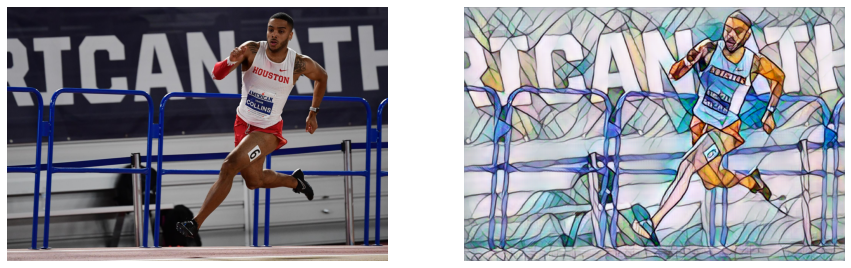

In [25]:
fig, ax = plt.subplots(1,2,figsize=(15,15))
ax[0].imshow((Headline & key).fetch1('image'))
ax[0].axis(False)
ax[1].imshow((Flyer & key).fetch1('image'))
ax[1].axis(False);

# Clean up and remove generated data

In [26]:
schema.drop()

Proceed to delete entire schema `dimitri_style`? [yes, No]: yes


In [27]:
import shutil
shutil.rmtree('cached')